## Customer Churn Prediction - Bank

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report 
import subprocess
import joblib
# Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Reading the DataSet

In [2]:
dc = pd.read_csv("E:/AMotefaker/ABC/Data Analyst/Sales Data Analysis/Customer Churn Prediction - Bank/Churn_Modelling.csv") 

In [3]:
dc.head(5) 

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Exploratory Data Analysis

In [4]:
# Dimension of the dataset
dc.shape

(10000, 14)

In [5]:
# Describe all numerical columns
dc.describe(exclude= ['O'])

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# Describe all categorical columns
dc.describe(include = ['O'])

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [7]:
# Checking number of unique customers in the dataset
dc.shape[0], dc.CustomerId.nunique()

(10000, 10000)

- This means each row corresponds to a customer.

In [8]:
# churn value Distribution
dc["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

- The data set is imbalanced from the above result, with a significant chunk of existing customers relative to their churned peers.

#### Group by Surname to see the average churn value:

In [9]:
dc.groupby(['Surname']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False).head()

,Surname,RowNumber,Exited
2473,Smith,32,0.281250
1689,Martin,29,0.310345
2389,Scott,29,0.103448
2751,Walker,28,0.142857
336,Brown,26,0.192308


#### Group by Geography:

In [10]:
dc.groupby(['Geography']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False)

,Geography,RowNumber,Exited
0,France,5014,0.161548
1,Germany,2509,0.324432
2,Spain,2477,0.166734


- From what we see above, customers from "Germany" have a higher exiting rate than average.

#### Univariate Plots of Numerical Variables

<AxesSubplot: ylabel='CreditScore'>

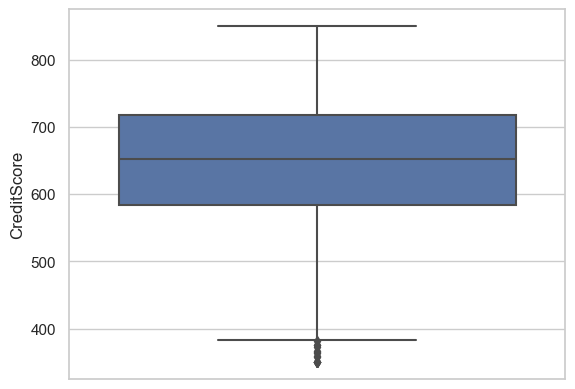

In [11]:
# Plotting CreditScore
sns.set(style="whitegrid")
sns.boxplot(y=dc['CreditScore'])

<AxesSubplot: ylabel='Age'>

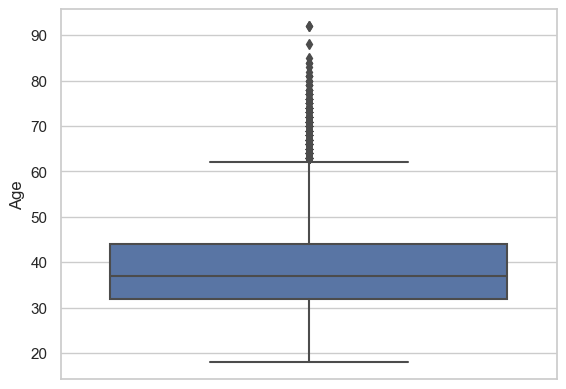

In [12]:
# Plotting Age
sns.boxplot(y=dc['Age'])

<AxesSubplot: ylabel='Tenure'>

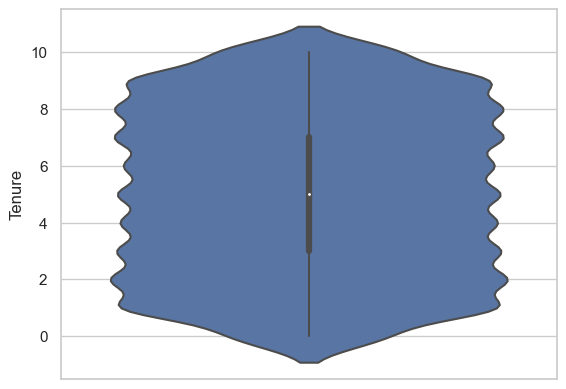

In [13]:
# Tenure violin plot
sns.violinplot(y = dc.Tenure)

<AxesSubplot: ylabel='Balance'>

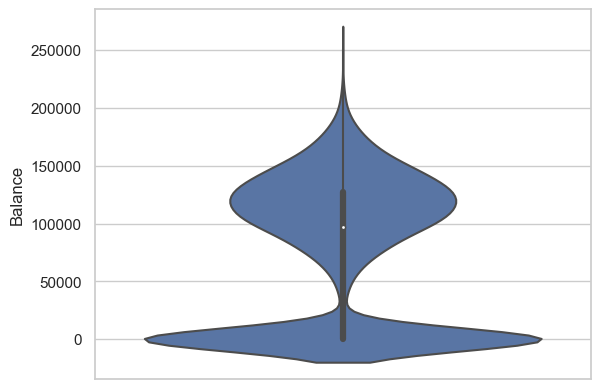

In [14]:
# Balance violin plot
sns.violinplot(y = dc['Balance'])

<AxesSubplot: xlabel='NumOfProducts'>

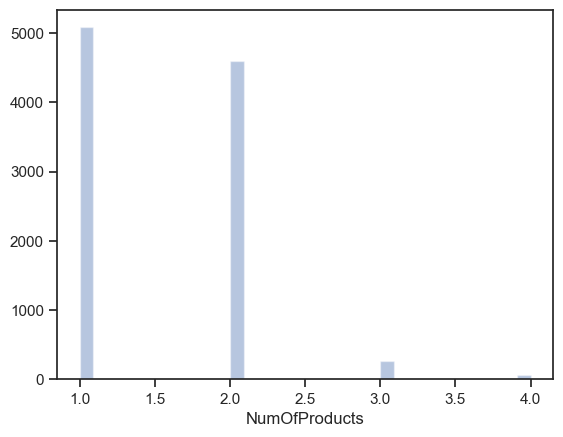

In [15]:
# Plotting a distribution plot of NumOfProducts
sns.set(style = 'ticks')
sns.distplot(dc.NumOfProducts, hist=True, kde=False)

- Most of the customers have 1 or 2 products.

<AxesSubplot: xlabel='EstimatedSalary', ylabel='Density'>

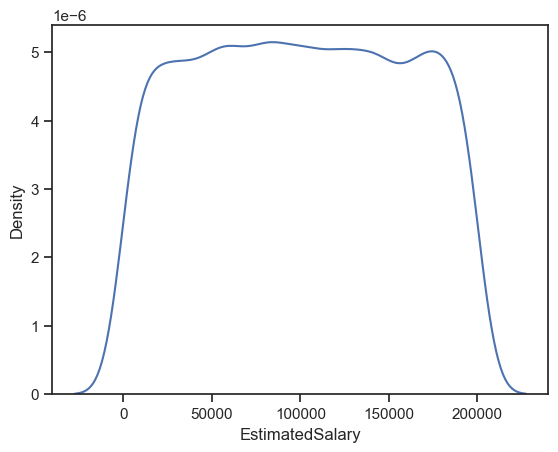

In [16]:
# Kernel density estimation plot for EstimatedSalary
# When dealing with numerical characteristics, one of the most useful statistics to examine is the data distribution.
# we can use Kernel-Density-Estimation plot for that purpose. 
sns.kdeplot(dc.EstimatedSalary)

### Data Preprocessing

Tips:

- We will discard the RowNumber column.
- We will discard CustomerID as well since it doesn't convey any extra info. Each row pertains to a unique customer.
- Features can be segregated into non-essential, numerical, categorical, and target variables based on the above.
- CustomerID is a handy feature based on which we can calculate many user-centric features.

In [17]:
# Separating out different columns into various categories as defined above
target_var = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']
# numerical columns
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
# categorical columns
cat_feats = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

- Tenure and NumOfProducts are ordinal variables. 
- HasCrCard and IsActiveMember are binary categorical variables.

In [18]:
# Separating target variable and removing the non-essential columns
y = dc[target_var].values
dc.drop(cols_to_remove, axis=1, inplace=True)

### Splitting Dataset

- We keep aside a test set to evaluate our model at the very end to estimate our chosen model's performance on unseen data.
- A validation set is also created, which we'll use in our baseline models to evaluate and tune our models.

In [19]:
# Keeping aside a test/holdout set
dc_train_val, dc_test, y_train_val, y_test = train_test_split(dc, y.ravel(), test_size = 0.1, random_state = 42)

# Splitting into train and validation set
dc_train, dc_val, y_train, y_val = train_test_split(dc_train_val, y_train_val, test_size = 0.12, random_state = 42)
dc_train.shape, dc_val.shape, dc_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7920, 12), (1080, 12), (1000, 12), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

### Categorical Variable Encoding

- 1- Label Encoding: transforms non-numerical labels into numerical ones. It can be used for binary categorical and ordinal variables.

- 2- One-Hot encoding: encodes categorical features as a one-hot numeric array. It can be used for non-ordinal categorical variables with low to mid cardinality (< 5-10 levels)

- 3- Target encoding: the technique of substituting a categorical value with the mean of the target variable is known as target encoding. The target encoder model automatically removes any non-categorical columns. It can be used for Categorical variables with > 10 levels


- HasCrCard and IsActiveMember are already label encoded.
- Gender, a simple label encoding should be acceptable.
- Geography, since there are three levels, one-hot encoding should do the trick.
- Surname, we'll try target/frequency encoding.

### 1- Label Encoding

#### Label Encoding for Binary Variables
- Label encoding on the Gender column.

In [20]:
# label encoding With  the sklearn method
le = LabelEncoder()
# Label encoding of Gender variable
dc_train['Gender'] = le.fit_transform(dc_train['Gender'])
le_gender_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_gender_mapping

{'Female': 0, 'Male': 1}

#### Testing and validation sets

In [21]:
# Encoding Gender feature for validation and test set
dc_val['Gender'] = dc_val.Gender.map(le_gender_mapping)
dc_test['Gender'] = dc_test.Gender.map(le_gender_mapping)

# Filling missing/NaN values created due to new categorical levels
dc_val['Gender'].fillna(-1, inplace=True)
dc_test['Gender'].fillna(-1, inplace=True)

#### Checking the values on all sets

In [22]:
dc_train.Gender.unique(), dc_val.Gender.unique(), dc_test.Gender.unique()

(array([1, 0]), array([1, 0]), array([1, 0]))

### 2- One-Hot encoding

#### One-hot Encoding Categorical Variables

In [23]:
# one-hot encode the Geography column

# With the sklearn method(LabelEncoder())
le_ohe = LabelEncoder()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
enc_train = le_ohe.fit_transform(dc_train.Geography).reshape(dc_train.shape[0],1)
ohe_train = ohe.fit_transform(enc_train)
ohe_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [24]:
# mapping between classes
le_ohe_geography_mapping = dict(zip(le_ohe.classes_, le_ohe.transform(le_ohe.classes_)))
le_ohe_geography_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

#### Testing and validation sets

In [25]:
# Encoding Geography feature for validation and test set
enc_val = dc_val.Geography.map(le_ohe_geography_mapping).ravel().reshape(-1,1)
enc_test = dc_test.Geography.map(le_ohe_geography_mapping).ravel().reshape(-1,1)

# Filling missing/NaN values created due to new categorical levels
enc_val[np.isnan(enc_val)] = 9999
enc_test[np.isnan(enc_test)] = 9999
ohe_val = ohe.transform(enc_val)
ohe_test = ohe.transform(enc_test)

- In case there is a country that isn't present in the training set, the resulting vector will simply be [0, 0, 0]:

In [26]:
# Show what happens when a new value is inputted into the OHE 
ohe.transform(np.array([[9999]]))

array([[0., 0., 0.]])

#### Adding the one-hot encoded columns to the data frame and removing the original feature:

In [27]:
cols = ['country_' + str(x) for x in le_ohe_geography_mapping.keys()]
cols

['country_France', 'country_Germany', 'country_Spain']

In [28]:
# Adding to the respective dataframes
dc_train = pd.concat([dc_train.reset_index(), pd.DataFrame(ohe_train, columns = cols)], axis = 1).drop(['index'], axis=1)
dc_val = pd.concat([dc_val.reset_index(), pd.DataFrame(ohe_val, columns = cols)], axis = 1).drop(['index'], axis=1)
dc_test = pd.concat([dc_test.reset_index(), pd.DataFrame(ohe_test, columns = cols)], axis = 1).drop(['index'], axis=1)
print("Training set")
dc_train.head()
print("\n\nValidation set")
dc_val.head()
print("\n\nTest set")
dc_test.head()

Training set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,Germany,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,France,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,France,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,France,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,France,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0




Validation set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Sun,757,France,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0
1,Russo,552,France,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0
2,Munro,619,France,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0
3,Perkins,633,France,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0
4,Aliyeva,698,Spain,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0




Test set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Anderson,596,Germany,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0
1,Herring,623,France,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0
2,Amechi,601,Spain,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0
3,Liang,506,Germany,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0
4,Chuang,560,Spain,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0


#### Dropping the original Geography column now:

In [29]:
dc_train.drop(['Geography'], axis=1, inplace=True)
dc_val.drop(['Geography'], axis=1, inplace=True)
dc_test.drop(['Geography'], axis=1, inplace=True)

### 3- Target encoding

- Target encoding is generally proper when dealing with categorical variables of high cardinality (high number of levels). 

#### Encode the Surname column (which has 2932 different values!) with the mean of the target variable for that level:

In [30]:
means = dc_train.groupby(['Surname']).Exited.mean()
means.head()
means.tail()

Surname
Abazu       0.00
Abbie       0.00
Abbott      0.25
Abdullah    1.00
Abdulov     0.00
Name: Exited, dtype: float64

Surname
Zubarev     0.0
Zubareva    0.0
Zuev        0.0
Zuyev       0.0
Zuyeva      0.0
Name: Exited, dtype: float64

#### Global mean of Exited column:

In [31]:
global_mean = y_train.mean()
global_mean

0.20303030303030303

In [32]:
# Creating new encoded features for surname - Target (mean) encoding
dc_train['Surname_mean_churn'] = dc_train.Surname.map(means)
dc_train['Surname_mean_churn'].fillna(global_mean, inplace=True)

##### The problem with target encoding is that it might cause "data leakage", as we are considering feedback from the target variable while computing any summary statistic. 

- A solution is to use a modified version: Leave-one-out Target encoding; for a particular data point or row, the mean of the target is calculated by considering all rows in the same definite level except itself. It mitigates data leakage and overfitting to some extent.

#### Calculating the frequency of each Surname:

In [33]:
freqs = dc_train.groupby(['Surname']).size()
freqs.head()

Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     1
dtype: int64

#### Create frequency encoding - Number of instances of each category in the data:

In [34]:
dc_train['Surname_freq'] = dc_train.Surname.map(freqs)
dc_train['Surname_freq'].fillna(0, inplace=True)

#### Creating Leave-one-out target encoding for Surname:

In [35]:
dc_train['Surname_enc'] = ((dc_train.Surname_freq * dc_train.Surname_mean_churn) - dc_train.Exited)/(dc_train.Surname_freq - 1)
# Fill NaNs occuring due to category frequency being 1 or less
dc_train['Surname_enc'].fillna((((dc_train.shape[0] * global_mean) - dc_train.Exited) / (dc_train.shape[0] - 1)), inplace=True)
dc_train.head(5)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000


#### On the validation and testing set, we'll apply the regular target encoding mapping as obtained from the training set:

In [36]:
# Replacing by category means and new category levels by global mean
dc_val['Surname_enc'] = dc_val.Surname.map(means)
dc_val['Surname_enc'].fillna(global_mean, inplace=True)
dc_test['Surname_enc'] = dc_test.Surname.map(means)
dc_test['Surname_enc'].fillna(global_mean, inplace=True)
# Show that using LOO Target encoding decorrelates features
dc_train[['Surname_mean_churn', 'Surname_enc', 'Exited']].corr()

,Surname_mean_churn,Surname_enc,Exited
Surname_mean_churn,1.000000,0.54823,0.562677
Surname_enc,0.548230,1.00000,-0.026440
Exited,0.562677,-0.02644,1.000000


- As you can see, "Surname_enc" isn't highly correlated with "Exited" as "Surname_mean_churn", so Leave-one-out is effective here.

#### Deleting the Surname and other redundant columns across the three datasets:

In [37]:
dc_train.drop(['Surname_mean_churn'], axis=1, inplace=True)
dc_train.drop(['Surname_freq'], axis=1, inplace=True)
dc_train.drop(['Surname'], axis=1, inplace=True)
dc_val.drop(['Surname'], axis=1, inplace=True)
dc_test.drop(['Surname'], axis=1, inplace=True)
dc_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000


#### Summary:

- Use label encoding and one-hot encoding on the training set and then save the mapping and apply it to the test set. For missing values, use 0, -1 etc.

- Target/Frequency encoding: Create a mapping between each level and a statistical measure (mean, median, sum, etc.) of the target from the training dataset. For the new categorical levels, impute the missing values suitably (can be 0, -1, or mean/mode/median).

- Leave-one-out or Cross-fold Target encoding avoids data leakage and helps generalize the model.

### Bivariate Analysis

#### Checking the linear correlation between individual features and the target variable:

In [38]:
corr = dc_train.corr()

<AxesSubplot: >

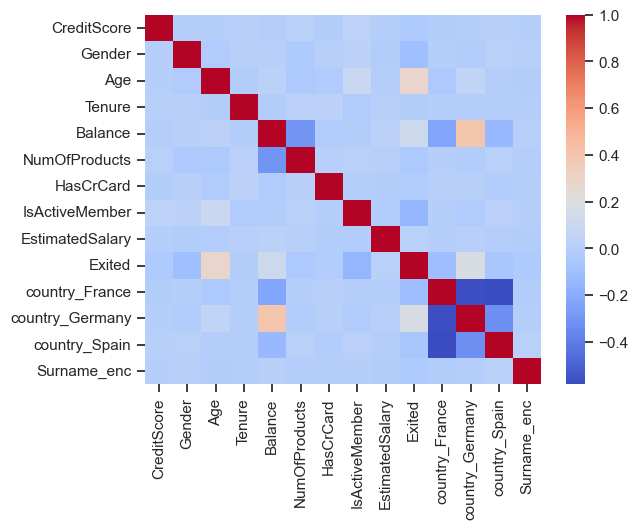

In [39]:
# Drawing a heatmap
sns.heatmap(corr, cmap = 'coolwarm')

- None of the features are highly correlated with the target variable. 
  But some of them have slight linear associations with the target variable:

    - Continuous features: Age, Balance.
    - Categorical variables: Gender, IsActiveMember, country_Germany, country_France.

#### Individual features versus their distribution across target variable values, for "Age" column:

<AxesSubplot: xlabel='Exited', ylabel='Age'>

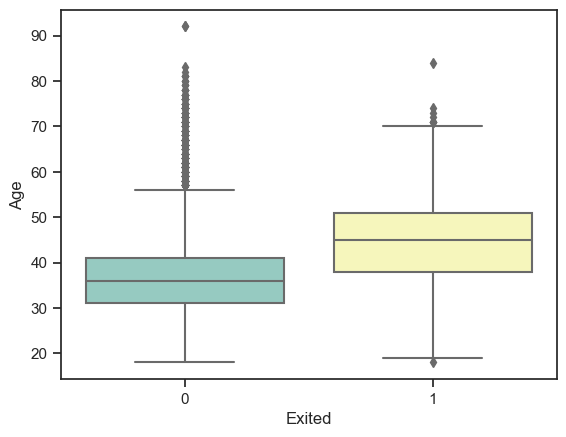

In [40]:
sns.boxplot(x="Exited", y="Age", data=dc_train, palette="Set3")

- Tips:
    - There is an outside point at 90 for class 0 and 83 for class 1.
    - The Median is around 35 for class 0 and 45 for class 1.
    - The lower adjacent value is a bit less than 20 for both classes.
    - The upper adjoining value is around 55 for class 0 and more than 70 for class 1.

####  Violin plot for the "Balance":

<AxesSubplot: xlabel='Exited', ylabel='Balance'>

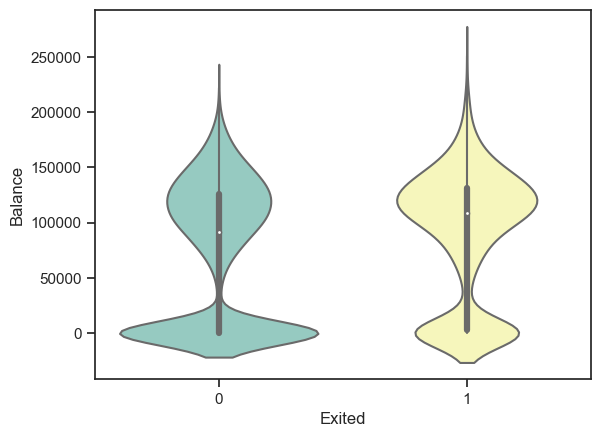

In [41]:
sns.violinplot(x="Exited", y="Balance", data=dc_train, palette="Set3")

- We see a high probability of observation at 125000 (balance) and a peak at 0 (balance) for class 0.